In [103]:
# consolidated training/evaluation of final models
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [104]:
df = pd.read_csv('data.csv', sep = ';', header=0)
cols = ['marital_status', 'app_mode', 'app_order', 'course', 'day_evening', 'prev_qual', 'prev_qual_grade', 'nationality', 'mother_qual',
        'father_qual', 'mother_occupation', 'father_occupation', 'admission_grade', 'displaced', 'special_needs', 'debtor', 'tuition_updated',
        'gender', 'scholarship', 'enrolled_age', 'international', 'sem1_units_credited', 'sem1_units_enrolled', 'sem1_unit_evals', 'sem1_unit_approved',
        'sem1_grades', 'sem1_units_noeval', 'sem2_units_credited', 'sem2_units_enrolled', 'sem2_unit_evals', 'sem2_unit_approved', 'sem2_grades',
        'sem2_units_noeval', 'unemployment', 'inflation', 'gdp', 'target']
df.columns = cols
df.head()

,marital_status,app_mode,app_order,course,day_evening,prev_qual,prev_qual_grade,nationality,mother_qual,father_qual,...,sem2_units_credited,sem2_units_enrolled,sem2_unit_evals,sem2_unit_approved,sem2_grades,sem2_units_noeval,unemployment,inflation,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [105]:
# dataset currently has target encoded as a 3-way classification.  since we haven't addressed this yet via the class, adding a separate column
# to turn this into a binary classification problem (either dropped out or not).  Stretch goal will be to evaluate both binary and multi-state classifications...
target_trans = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 0}
df['dropout'] = df['target'].apply(lambda x: target_trans[x])
target_trans = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}
df['target'] = df['target'].apply(lambda x: target_trans[x])  # make all columns numeric

In [106]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 11)
df_full_train = df_full_train.reset_index(drop = True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train.dropout.values
y_test = df_test.dropout.values

df_full_train.drop(['dropout', 'target'], axis=1, inplace=True)
df_test.drop(['dropout', 'target'], axis=1, inplace=True)

In [107]:
dv = DictVectorizer(sparse=False)

train_dict = df_full_train.to_dict(orient = 'records')
test_dict = df_test.to_dict(orient = 'records')

X_train = dv.fit_transform(train_dict)
X_test = dv.transform(test_dict )

# Linear Regression

In [108]:
from sklearn.preprocessing import StandardScaler  #significantly reduces run time and produces roughly identical results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scale_model = LogisticRegression(C=10)
scale_model.fit(X_train_scaled, y_full_train)
logr_y_pred_scale = scale_model.predict_proba(X_test_scaled)[:,1]
print('Scaled logistic regression model AUC = %.3f' % (roc_auc_score(y_test, logr_y_pred_scale)))

Scaled logistic regression model AUC = 0.911


In [109]:
import pickle
with open('log_reg_model.bin', 'wb') as f_out:  # 'wb' means write-binary
    pickle.dump((dv, scale_model), f_out)

with open('scaler.bin', 'wb') as f_out:
    pickle.dump(scaler, f_out)

print(f'Model saved to log_reg_model.bin')

Model saved to log_reg_model.bin


## Core functions

In [112]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, X_train, model

In [113]:
def predict(df, dv, model):
    dicts = df.to_dict(orient = 'records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

## Decision Tree

In [114]:
#final DecisionTree model
dt = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 95)
dt.fit(X_train, y_full_train)
dt_y_pred = dt.predict_proba(X_test)[:,1]
print('Decision Tree score = %.3f' % (roc_auc_score(y_test, dt_y_pred)))

Decision Tree score = 0.872


## Random Forest

In [115]:
#final RandomForest model
rf = RandomForestClassifier(n_estimators = 125, max_depth = 15, min_samples_leaf = 5, random_state = 1)
rf.fit(X_train, y_full_train)
rf_y_pred = rf.predict_proba(X_test)[:,1]
print('RandomForest score = %.3f' % (roc_auc_score(y_test, rf_y_pred)))

RandomForest score = 0.905


## XGBoost

In [117]:
#final GradientBoost model
xgb_params = {
        'eta': 0.05,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 4,
        'seed': 1,
        'verbosity': 1,
    }

features = list(dv.get_feature_names_out())
d_fulltrain = xgb.DMatrix(X_train, label = y_full_train, feature_names = features)
d_test = xgb.DMatrix(X_test, feature_names = list(dv.get_feature_names_out()))

xgb_model = xgb.train(xgb_params,d_fulltrain, num_boost_round = 150)
xgb_y_pred = xgb_model.predict(d_test)
print('XGBoost AUC score = %.3f' % roc_auc_score(y_test, xgb_y_pred))

XGBoost AUC score = 0.916


## Summary

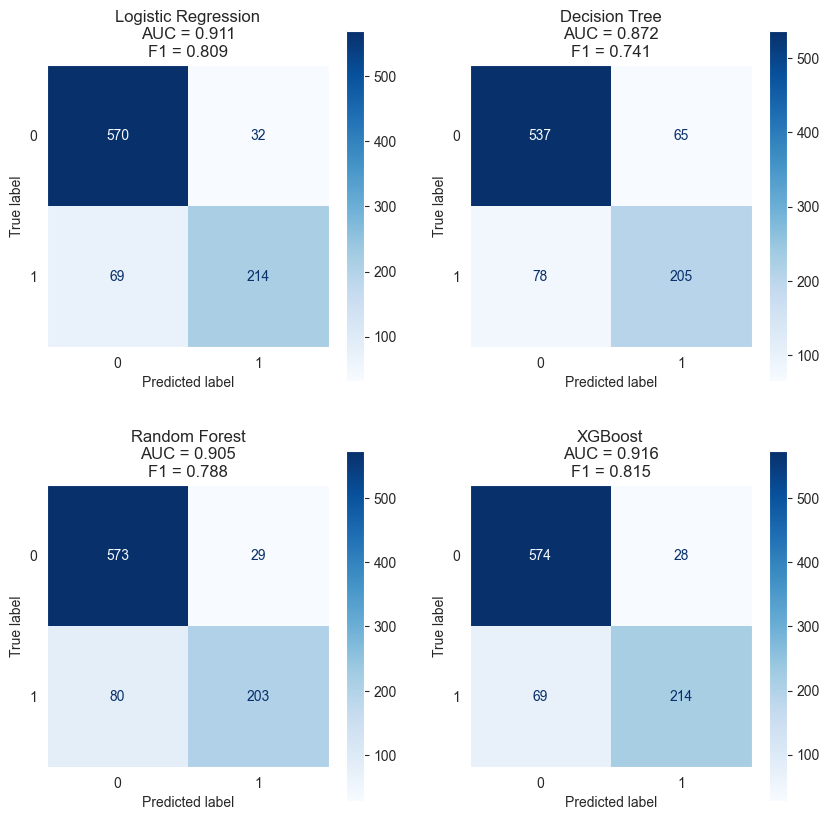

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

fig, axes = plt.subplots(2, 2, figsize = (10,10))

disp_log = ConfusionMatrixDisplay.from_predictions(y_test, (logr_y_pred_scale >= 0.5).astype(int), cmap = 'Blues', ax = axes[0][0]).ax_.grid(False)
disp_dt = ConfusionMatrixDisplay.from_predictions(y_test, (dt_y_pred >= 0.5).astype(int), cmap = 'Blues', ax= axes[0][1]).ax_.grid(False)
disp_rf = ConfusionMatrixDisplay.from_predictions(y_test, (rf_y_pred >= 0.5).astype(int), cmap = 'Blues', ax= axes[1][0]).ax_.grid(False)
disp_xgb = ConfusionMatrixDisplay.from_predictions(y_test, (xgb_y_pred >= 0.5).astype(int), cmap = 'Blues', ax = axes[1][1]).ax_.grid(False)

axes[0][0].set_title('Logistic Regression\nAUC = %.3f\nF1 = %.3f' % (roc_auc_score(y_test, logr_y_pred_scale), f1_score(y_test, (logr_y_pred_scale >= 0.5).astype(int))))
axes[0][1].set_title('Decision Tree\nAUC = %.3f\nF1 = %.3f' % (roc_auc_score(y_test, dt_y_pred), f1_score(y_test, (dt_y_pred >= 0.5).astype(int))))
axes[1][0].set_title('Random Forest\nAUC = %.3f\nF1 = %.3f' % (roc_auc_score(y_test, rf_y_pred), f1_score(y_test, (rf_y_pred >= 0.5).astype(int))))
axes[1][1].set_title('XGBoost\nAUC = %.3f\nF1 = %.3f' % (roc_auc_score(y_test, xgb_y_pred), f1_score(y_test, (xgb_y_pred >= 0.5).astype(int))))

plt.show()